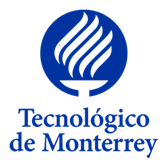

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 4

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Configuración la Base de Conocimiento y el Modelo Fundacional**

<img src="./Proyecto Integrador - RAG con Bedrock-Smart Travel Assistant KB v1.00 con LangChain.drawio.png" alt="RAG Bedrock KB V1.00" />

Para crear el modelo de referencia para este proyecto se creo una base de datos de conocimientos en **AWS Bedrock**. El proceso es el siguiente:
1. Crear la base de conocimientos, o **Knowledge Base**. Para este proyecto la base de conocimiento se llama *Volindo-hotels* y se usa una base de datos de vectores de **Pinecone**
> * La fuente de conocimiento incluye 246 pares de archivos de MS Excel y JSON con los datos de más de 145,000 hoteles. Cada par de archivos representa un país.
2. Cargar los datos en un Bucket de S3, llamado *hotel-clean-data*
3. Asociar el Bucket de S3 como una fuente de información para la base de conocimiento
4. Sincronizar (cargar) los datos de la fuente de información

Una vez cargado la base de conocimiento se puede probar usando la consola de AWS Bedrock o a través de APIs, tal y como se hará a continuación.

## **Probando la Base de Conocimiento y el Modelo Fundacional**

### **Preparando el Ambiente de Ejecución**

Es necesario importar las librerías necesarias para iniciar una sesión de AWS y para registrar una bitácora de ejecución.

In [7]:
!pip install langchain

In [8]:
!pip install langchain-community

In [9]:
!pip install langchain-text-splitters

In [10]:
!pip install langchain-aws

In [11]:
# Importando librerias requeridas
import time
import re
import json
import uuid
import io
import logging
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import boto3

from langchain_community.retrievers import AmazonKnowledgeBasesRetriever
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_aws import BedrockLLM


In [12]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
#logging.basicConfig(
#    filename='../logs/Avance4_Equipo37_Bedrock_Alternative.log',
#    level=logging.INFO,
#    format='%(asctime)s %(levelname)-8s %(message)s',
#    datefmt='%Y-%m-%d %H:%M:%S'
#)

In [13]:
# Configurando constantes para la ejecución. AWS_KBID contiene el identificador de la base de conocimientos de AWS Bedrock
LOCAL_SET = '../local-responses'
AWS_KBID = '5XNHOMTE5G'


### **Evaluando la Base de Conocimiento y el Modelo Fundacional**

AWS Bedrock provee tres tipos de mecanismos para evaluar el desempeño de los modelos fundacionales:
* Evaluación automatizada
* Evaluación por un equipo de humanos
* Evaluación por un servicio de evaluación de AWS

La evaluación automatizada permite hacer evaluaciones de la precisión del modelo, la toxicidad de las respuestas y la robustes de las respuestas.
Desafortunadamente AWS solo ofrece este servicio para solo uno de los modelos de Amazon y no cubre la evaluación de la base de conocimiento y de las respuestas generadas en combinación con el modelo fundacional de Titan Text Premier.

Dada esta limitación el equipo decidió establecer un proceso de evaluación por un equipo de personas. Cada miembro:
* creó varias preguntas relacionadas a hoteles y lugares
* alimentó las preguntas a la base de conocimiento y el modelo fundacional y a Copilot Edge
* preparó un análisis comparativo de las respuestas recibidas.


### **Creando Agente para Recuperar Informacion de Contexto**

In [14]:
# Creando sesion para AWS Bedrock. Credenciales y configuracion se obtienen de ~/.aws
retriever = AmazonKnowledgeBasesRetriever(
    knowledge_base_id=AWS_KBID,
    retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 5}},
)

### **Creando Agente para Questionar el Modelo Fundacional**

In [15]:
model_kwargs_premier = {'temperature': 0, 'topP': 0.7, 'maxTokenCount': 3000}
llm = BedrockLLM(model_id='amazon.titan-text-premier-v1:0', model_kwargs=model_kwargs_premier)

### **Creando Función para Solictar Respuestas de AWS Bedrock y para Desplegarlas**

In [16]:
# Creando función para buscar información en la base de conocimiento y generar una respuesta usando el modelo fundacional
# Titan Text Premier de AWS Bedrock. La función también calcula el tiempo de ejecución
def retrieve_and_generate(query, retriever, llm):
    start_time = time.time()
    system_prompt = (
        "You are a friendly and helpful travel assistant."
        "Use the given context to answer the question."
        "Select options in the same city or near by."
        "Provide two or three options if possible."
        "Use the name provided in the context."
        "If you don't know the answer, say you don't know. "
        "Use three sentence maximum and keep the answer concise. "
        "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    chain = create_retrieval_chain(retriever, question_answer_chain)
    
    response = chain.invoke({"input": query})
    elapsed_time = time.time() - start_time
    return elapsed_time, response


In [17]:
# Creando función desplegar la respuesta recibida de AWS. La respuesta incluye diferentes valores como la respuesta completa,
# la respuesta en partes, o citas, con referencias y los metadatos de cada referencia
def display_response(response, elapsed_time):
    # desplegando respuestas
    print(f"Respuesta despues de {elapsed_time:.4f} segundos:\n{response['answer']}")
    for context in response['context']:
        print(f"\nContexto:\n{context.page_content}")
        print(f"\nCalificacion:{context.metadata['score']:.6f}")
        print(f"\nPais: {context.metadata['source_metadata']['Country']}, Continente:{context.metadata['source_metadata']['Continent']}, URI:{context.metadata['source_metadata']['x-amz-bedrock-kb-source-uri']}")


### **Ejecutando la Evaluación**

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [18]:
input = '''Can you suggest accomodation near pilanesberg national park in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 11.7819 segundos:
Here are some options for accommodation near Pilanesberg National Park in South Africa:
1. Newlands Cottages - This 4-star cottage is located in Cape Town, a 2-minute drive from the University of Cape Town and 7 minutes from Kirstenbosch National Botanical Gardens. It offers individually decorated guestrooms with fireplaces and private pools, as well as kitchens with full-sized refrigerators/freezers, stovetops, and microwaves.
2. Sea Otters Lodge - This lodge is situated by its own private area on Kini Bay's beach and boasts picturesque sea views and soundproofed rooms with satellite TV. It offers free limited WiFi access, a traditional braai (barbecue) facility, and an honesty bar. Guests can explore the surrounding area while hiking or horse riding, or rent a car to explore further afield.
3. Mountain Cabin - This 4-star cabin is located in Wolseley and is in a rural location, within a 15-minute drive of Cape Floral Region Protected Areas and D

**Respuesta de Copilot Edge**

Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing1.
Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.
Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.
Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.
Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.
Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction

**Análisis**

La repuesta obtenida del modelo y la base de conocimiento es bastante completo y preciso y probablemente una de las mejores respuestas proporcionadas.
Los lugares sugeridos están ubicados en la vecindad del parque nacional de Pilanesberg y son bien conocidos.

Las descripciones proporcionada por Copilot Edge concuerda con la presentada por el modelo y la base de conocimiento.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [19]:
input = '''Can you suggest accomodation near pilanesberg national park in the north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 6.6579 segundos:
Here are some options for accommodation near Pilanesberg National Park in the North West Province of South Africa:

1. Black Rhino Game Lodge: This lodge is located within the Pilanesberg National Park and offers luxurious accommodations, game drives, and other activities.

2. Bakubung Bush Lodge: This lodge is also located within the Pilanesberg National Park and offers a range of accommodations, from standard rooms to luxury suites. It also has a spa, swimming pool, and restaurant.

3. Tshukudu Bush Lodge: This lodge is located on the outskirts of the Pilanesberg National Park and offers a more intimate and exclusive experience. It has just four chalets, each with its own private deck and plunge pool.

4. Kwa Maritane Bush Lodge: This lodge is located on the outskirts of the Pilanesberg National Park and offers a range of accommodations, from standard rooms to luxury suites. It also has a spa, swimming pool, and restaurant.

5. The Kingdom Resort

**Respuesta de Copilot Edge**

Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing1.
Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.
Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.
Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.
Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.
Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction

**Análisis**

El agregar una pieza adicional de información, en la forma del nombre de la provincia donde se localiza el parque, no le permitió al modelo y la base de conocimiento presentar una respuesta valida. Las opciones de hospedaje presentadas, si bien están en Sudáfrica, se localizan en otras provincias y algunos casos la recomendación incluye opciones en el otro lado del país.

Analizando las citas y referencias presentadas se puede observar que el texto incluye el nombre del parque, pero el resto de la descripción pertenece a otro hotel en otra provincia. Esto parece indicar que habrá que hacer ajustes al tamaño del pedazo usado para crear los vectores.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [20]:
input = '''What attractions are close to Black Rhino Game Lodge, north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 1.4195 segundos:
I don't know.

Contexto:
The host will greet guests on arrival.&nbsp;Disclaimer notification: Amenities are subject to availability and may be chargeable as per the hotel policy.	esplanade road century city, , cape town, 7400, south africa	7400	ZA	27-86-1112842	Cape Town	18.510996	-33.890837	4 	1227974	rhino ridge safari lodge	HeadLine : In a national parkLocation : With a stay at Rhino Ridge Safari Lodge in Hlabisa, you ll be 1.6 mi (2.7 km) from Hluhluwe–Imfolozi Park and 23.5 mi (37.8 km) from Centenary Centre.  This 4-star lodge is 27.4 mi (44.1 km) from Zululand Rhino Reserve and 29.7 mi (47.8 km) from Manyoni Private Game Reserve.Rooms : Make yourself at home in one of the 16 air-conditioned rooms featuring minibars. Conveniences include safes and coffee/tea makers, and housekeeping is provided daily.Dining : At Rhino Ridge Safari Lodge, enjoy a satisfying meal at the restaurant. Wrap up your day with a drink at the bar/lounge.

Calificacion:

**Respuesta de Copilot Edge**

The Black Rhino Game Lodge is nestled in the west side of the malaria-free Pilanesberg National Park in the North West Province of South Africa. Here are some attractions near the lodge:

Pilanesberg National Park: The park itself is a must-visit, covering an area of 55,000 hectares. It’s home to the Big Five (elephant, buffalo, leopard, lion, and rhinoceros), as well as other wildlife like wild dogs, hippos, and various bird species12.
Sun City: Only 33 km away from the lodge, Sun City is a popular entertainment hotspot. You can explore its casinos, golf courses, water parks, and cultural attractions1.
Tambuti Lodge: Located in the northwestern side of Pilanesberg National Park, Tambuti Lodge offers spacious and luxurious accommodation surrounded by the trees of the old Tamboti forest. It’s an excellent option for visitors seeking a unique safari experience3.
Kgorogoro Lodge (Morokolo Safari Lodge): Situated on the northern slopes of the Pilanesberg mountains, Kgorogoro Lodge boasts rich varieties of African wildlife, fauna, and flora. You can book either the 4 Suite Lodge or the Executive Suite for a memorable stay4.
Remember that the Black Rhino Game Reserve and the greater Pilanesberg National Park are only about 2.5 hours’ drive from Johannesburg, Pretoria, and the OR Tambo International Airport, making it easily accessible for travelers1. Enjoy your bushveld adventure! raction

**Análisis**

Una respuesta sencilla, aunque con merito, ya que el parque nacional es la atracción principal y la más extensa en la región. La única diferencia con respecto a la respuesta de Copilot Edge es que esta última incluye Sun City, otro conjunto de hoteles muy cercanos al parque que tiene un parque acuático.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [21]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 8.4324 segundos:
Here are some options for accommodation in Cape Town, Western Cape Province in South Africa:

1. The Westin Cape Town - a 4-star hotel located in the city center, connected to the convention center.
2. The Oracle - a 5-star villa in Camps Bay, close to the beach and Table Mountain.
3. Amafu Forest Lodge - a 5-star lodge in Hoedspruit, located in the mountains and near Blyderivierspoort Hiking Trail and Greater Kruger National Park.
4. Wescamp Villa - a 4-star villa in Camps Bay, with a private pool and views of the ocean and mountains.
5. Hotel Roosje van de Kaap - a 4-star guesthouse in Swellendam, with antique furnishings and a restaurant serving traditional South African and Cape Malay dishes.
6. Cotswold House - a 4-star guesthouse in Cape Town, located in Milnerton and close to the beach and shopping centers.
7. Hoopoe House - a 4.5-star villa in Camps Bay, with private pools and views of the ocean and mountains.
8. 25 On Chrisoliet - a 4-star

**Respuesta de Copilot Edge**

Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of accommodation options. Here are a few recommendations:

The Glen Boutique Hotel & Spa: A 5-star stay in Sea Point, Cape Town. Enjoy luxurious rooms with modern furniture, private bathrooms, and stunning views of the mountains or the Atlantic Ocean. The hotel features a spa, pool, and complimentary breakfast buffet1.
Radisson Blu Hotel Waterfront: Another 5-star option with breathtaking views of Table Mountain or the ocean. The hotel offers free Wi-Fi, a private marina, and water sports activities. It’s close to the V&A Waterfront and the CBD2.
Airbnb: Consider checking out Airbnb for unique vacation rentals, apartments, and townhouses in Cape Town. You can find places with ocean views, private pools, and stylish interiors34.
Remember to explore the Sea Point promenade, nearby beaches, and iconic attractions during your stay. Enjoy your trip!raction

**Análisis**

La respuesta proporcionada por el modelo y la base de conocimiento es parcialmente correcta ya que incluye tres hoteles localizados en la Ciudad del Cabo, tal y como se solicitó. Como en el caso anterior, las citas relacionadas con los hoteles incorrectos dejan ver que comparten porciones de una descripción parcial de un hotel en la Ciudad del Cabo, sin nombre con los detalles del hotel en Johannesburgo. Este es una indicación que hay que refinar el contenido de los archivos o cambiar el tamaño del pedazo o *chunk size*.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [22]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa, minimum rating of 4?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 8.1436 segundos:
Here are some options for accommodation in cape town, western cape province in south africa, with a minimum rating of 4:

1. Wescamp Villa - 4-star villa, located in Cape Town (Camps Bay), features separate sitting areas, coffee/tea makers, outdoor pool, wireless Internet access (surcharge), concierge services, babysitting/childcare (surcharge), and barbecue grills.

2. Four on C Luxury Suites by TotalStay - 4-star apartment, located in Cape Town (Sea Point), offers fireplaces, flat-screen televisions, furnished balconies, full-sized refrigerators/freezers, ovens, stovetops, and satellite television.

3. The Oracle - 5-star villa, located in Cape Town (Camps Bay), provides fireplaces, flat-screen televisions, private balconies, private kitchens, an outdoor pool, a spa tub, and barbecue grills.

4. Amafu Forest Lodge - 4.5-star villa, located in Hoedspruit, features a private pool, a flat-screen TV, a private furnished balcony, a kitchen with a full

**Respuesta de Copilot Edge**

Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of 4-star accommodation options. Here are some recommendations:

Home Suite Hotels Station House: Located in Sea Point, this hotel provides an outdoor swimming pool, free private parking, a fitness center, and a terrace. Guests can also enjoy a bar12.
Home Suite Hotels Sea Point: Set in Cape Town, near Three Anchor Bay Beach, this hotel features an outdoor swimming pool, shared lounge, and terrace. Some units even have a balcony with city views12.
O’ Two Hotel: Situated in Mouille Point, this hotel offers free bikes, an outdoor swimming pool, fitness center, and a terrace. It’s close to Mouille Point Beach and Three Anchor Bay Beach12.
Romney Park Luxury Apartments: Located in Green Point, this 5-star aparthotel offers spacious apartments with kitchen facilities, en-suite bathrooms, and outdoor balconies with panoramic views12.
Remember to explore the nearby attractions and enjoy your stay in beautiful Cape Town!raction

**Análisis**

Como en el caso anterior, la respuesta proporcionada por el modelo y la base de conocimiento es parcialmente correcta ya que incluye tres hoteles localizados en la Ciudad del Cabo, tal y como se solicitó. Como en el caso anterior, las citas relacionadas con los hoteles incorrectos dejan ver que comparten porciones de una descripción parcial de un hotel en la Ciudad del Cabo, sin nombre con los detalles del hotel en Johannesburgo. Este es una indicación que hay que refinar el contenido de los archivos o cambiar el tamaño del pedazo o *chunk size*.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [23]:
input = '''Can you suggest accommodation in Hoedspruit, limpopo province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 9.2779 segundos:
Here are some options for accommodation in Hoedspruit, Limpopo Province, South Africa:

1. Lemon Tree B&B - This bed and breakfast is located in Kloof and offers an outdoor pool, tennis court, and free Wi-Fi. It is 1 km from Kloof Maytime shopping centre and 35 km from King Shaka International Airport.

2. Sloane Square 7 - This apartment is centrally located in Cape Town and offers a kitchen with a full-sized refrigerator/freezer and an oven. It is 0.7 mi (1.2 km) from Kloof Street and 3.3 mi (5.3 km) from Table Mountain.

3. Valley Bushveld Country Lodge - This bed and breakfast is located in Addo and offers a family restaurant, bar/lounge, and garden view. It is 20.8 mi (33.5 km) from Addo Elephant National Park and 27.7 mi (44.6 km) from Nelson Mandela Bay Stadium.

4. ITC Hospitality Group Icon Building - This apartment is located in Cape Town City Centre and offers a kitchen with a full-sized refrigerator/freezer and an oven. It is steps from

**Respuesta de Copilot Edge**

Certainly! Hoedspruit, located in the Limpopo Province of South Africa, offers a variety of accommodation options. Here are some recommendations:

The Hoedspruit Hotel: This cozy hotel brings the best of Hoedspruit to your doorstep. Enjoy comfortable rooms with flat-screen TVs, air conditioning, and refrigerators. Free parking is available, and it’s conveniently located near popular art galleries and restaurants1.
Sunbirds Oasis Lodge: A tranquil stay in Hoedspruit. Explore the surrounding wildlife and enjoy the peaceful atmosphere2.
Airbnb: Consider checking out Airbnb for unique vacation rentals, self-catering houses, and lodges in Hoedspruit. You can find options with stunning views, private pools, and close proximity to nature reserves3.
Remember to explore the nearby Blyde River Canyon, Kruger National Park, and other natural wonders during your stay.raction

**Análisis**

La respuesta proporcionada por el modelo y la base de conocimiento es incorrecta ya que ninguno de los hoteles está localizado cerca de Hoedspruit. Como en el caso anterior, las citas relacionadas con los hoteles incorrectos dejan ver que comparten porciones de una descripción parcial de un hotel en la Hoedspruit, sin nombre con los detalles del hotel en otro lugar. Este es una indicación que hay que refinar el contenido de los archivos o cambiar el tamaño del pedazo o *chunk size*.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [24]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 2.4259 segundos:
Sure! Here are 5 places to stay in Monterrey, Nuevo Leon in Mexico:
1. Hotel Parque Central
2. Hotel El Rancho
3. Conrad San Luis Potosi
4. NH Monterrey La Fe
5. Hotel Hacienda Sánchez

Contexto:
The hotel has a bar and a restaurant. Other facilities include a business centre, a fitness centre as well as laundry and dry cleaning services.  Hotel Parque Central is 10 minutes’ drive from Cintermex Exhibition Centre and the Santa Lucia river walk. Monterrey International Airport is 35 minutes’ drive from the hotel. Food & beverage services at this property may be limited or unavailable due to Coronavirus (COVID-19). Due to Coronavirus (COVID-19), this property has reduced reception and service operating hours. In accordance with government guidelines to minimise transmission of the Coronavirus (COVID-19), this property may request additional documentation from guests to validate identity, travel itinerary and other relevant information, during dates w

**Respuesta de Copilot Edge**

Certainly! If you’re planning a trip to Monterrey, Nuevo León, here are five great places to stay:

Safi Royal Luxury Metropolitan: Located in San Pedro Garza Garcia, this 5-star hotel offers an outdoor pool, free parking, and a fitness center. Enjoy panoramic views and excellent service12.
Best Western PREMIER Monterrey Aeropuerto: Just a 5-minute drive from Monterrey International Airport, this hotel features an outdoor pool, a gym, and air-conditioned rooms with free Wi-Fi13.
Galeria Plaza Monterrey: Conveniently situated in the center of Monterrey, this 5-star hotel offers city views, an outdoor pool, and free WiFi. Don’t miss the restaurant and bar13.
Holiday Inn & Suites - Monterrey Apodaca Zona Airport: Located in Apodaca, this 5-star IHG hotel provides an outdoor pool, free private parking, and a fitness center. Perfect for travelers near the airport13.
Fiesta Americana Monterrey Pabellón M.: Situated in Monterrey Centro, this hotel offers an outdoor pool and stunning city views. The on-site restaurant and bar on the 16th floor provide a memorable experience12.
Enjoy your stay in vibrant Monterrey!raction

**Análisis**

La respuesta proporcionada incluye tres hoteles de Monterrey y hoteles en otros lugares. Como en los cases anterior, las citas relacionadas con los hoteles incorrectos dejan ver que comparten porciones de una descripción parcial de un hotel sin nombre con los detalles del hotel en Monterrey. Este es una indicación que hay que refinar el contenido de los archivos o cambiar el tamaño del pedazo o *chunk size*.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [25]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico, close to Tec de Monterrey?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 3.7394 segundos:
1. NH Monterrey La Fe - 1.5 km away from Tec de Monterrey.
2. Hotel El Rancho - 2.5 km away from Tec de Monterrey.
3. Hotel Parque Central - 3.5 km away from Tec de Monterrey.
4. Conrad San Luis Potosi - 4.5 km away from Tec de Monterrey.
5. Holiday Inn Monterrey Centro - 5 km away from Tec de Monterrey.

Contexto:
Popular points of interest near Galeria Plaza Monterrey include MARCO Museum Monterrey, Macroplaza and Pabellon M. The nearest airport is Monterrey International, 33 km from the accommodation, and the property offers a paid airport shuttle service.&nbsp;Disclaimer notification: Amenities are subject to availability and may be chargeable as per the hotel policy.	411 avenida constitución edificio, monterrey centro,, 64000 monterrey, mexico, monterrey, 64000, mexico	64000	MX	N/A	Monterrey	-100.32286	25.66608	5 	1404200	hotel hacienda sánchez	Featuring an outdoor swimming pool, Hacienda Sánchez is situated 1.5 km north of the historic centre

**Respuesta de Copilot Edge**

Certainly! If you’re looking for accommodations near Tec de Monterrey, here are five options to consider:

Safi Royal Luxury Metropolitan: Located in San Pedro Garza Garcia, this 5-star hotel offers an outdoor swimming pool, free private parking, a fitness center, and a restaurant. Enjoy a comfortable stay with excellent amenities1.
Best Western PREMIER Monterrey Aeropuerto: Just a 5-minute drive from Monterrey International Airport, this hotel features an outdoor pool, a gym, and air-conditioned rooms with free Wi-Fi1.
Galeria Plaza Monterrey: Attractively set in the center of Monterrey, this 5-star hotel offers air-conditioned rooms, an outdoor swimming pool, free Wi-Fi, and a fitness center. Enjoy city views and convenient amenities1.
Holiday Inn & Suites - Monterrey Apodaca Zona Airport: Situated in Apodaca, this 5-star IHG hotel provides an outdoor pool, free private parking, and a fitness center. Perfect for travelers near the airport1.
Fiesta Americana Monterrey Pabellón M.: Offering an outdoor pool and city views, this hotel is located in Monterrey Centro. Enjoy panoramic vistas from the on-site restaurant and bar on the 16th floor1.
These options provide a range of amenities and convenient locations for your stay in vibrant Monterrey!raction

**Análisis**

La respuesta recibida es consistente con la anterior pero se puede ver también que Copilot Edge tampoco pudo proveer hoteles cercanos al Tec de Monterrey, en Monterrey.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [26]:
input = '''I want to stay with my wife for a romantic weekend in Mexico City. We want to have a nice massage within the hotel.'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 2.6919 segundos:
I would recommend the Hotel Rancho Gran Relax. It is a luxurious hacienda-style hotel with a spa area and a business center. It is located near Mexico City and offers a multitude of possibilities for events, such as karting, a car race track, Gotcha or a shooting range. The on-site restaurant serves delicious Mexican and international cuisine.

Contexto:
Front desk staff will greet guests on arrival.&nbsp;Disclaimer notification: Amenities are subject to availability and may be chargeable as per the hotel policy.	24av. 16 de septiembre barrio de mexicanos, centro históricosan cristóbal de las casaschiapas, san cristobal de las casas, 29200, mexico	29200	MX	52-967-6747784	San Cristobal De Las Casas	-92.63877	16.739124	4 	1489571	hotel rancho gran relax	The luxurious hacienda-style Hotel Rancho Gran Relax is conveniently situated on a vast piece of land just a 20-minute drive away from the town of Tulancingo with its archaeological site and shopping 

**Respuesta de ChatGpt**

Mexico City offers many luxurious hotels perfect for a romantic weekend. Here are a few options that include massage services within the hotel:

1. Las Alcobas, a Luxury Collection Hotel
Located in the upscale Polanco district, Las Alcobas offers elegant rooms and a serene spa. The hotel features a full-service spa with a variety of massage treatments, ensuring a relaxing experience for you and your wife.

2. The St. Regis Mexico City
This hotel is known for its luxurious amenities and exceptional service. The Remède Spa offers a range of treatments, including massages, facials, and body treatments. The hotel’s central location also provides easy access to many of the city’s attractions.

3. Four Seasons Hotel Mexico City
Situated on the Paseo de la Reforma, this hotel combines luxury with comfort. The spa offers a variety of massage treatments, and you can also enjoy the beautiful garden courtyard and the rooftop pool.

4. Hotel Marquis Reforma
This elegant hotel on Paseo de la Reforma features the Spa Marquis, offering an extensive menu of massages and wellness treatments. It’s a perfect place to unwind and enjoy a romantic weekend.

5. JW Marriott Hotel Mexico City
Located in the Polanco district, this hotel offers a luxurious stay with an on-site spa that provides various massage treatments. The hotel’s prime location also means you’re close to excellent dining and shopping options.

These hotels will provide a romantic and relaxing environment for your weekend getaway.

**Análisis**

La respuesta de nuestro modelo no es acertada en cuanto a la ciudad requerida. Esto se puede deber a que estamos complementando al modelo con una parte del total de nuestros registros de hoteles. Aun así debemos de cuidar de que en la respuesta tenga mayor peso el destino el cual usuario está buscando.
Por otro lado la respuesta fue acertada en cuanto a las amenidades que se buscaban en el hotel, en este caso uns spa.

El resultado comparativo con chatgpt fue más acertado en cuanto a que los hoteles sugeridos si se encuentran en la ciudad destino.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [27]:
input = '''I want to do a a golf weekend with my friends in Cancun. What hotels do you recommend that have their own golf course?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 1.7394 segundos:
I recommend the Dreams Vista Cancun Golf & Spa Resort - All Inclusive, the Dreams Playa Mujeres Golf & Spa Resort All Inclusive and the Ocean Club Suites.

Contexto:
All rooms have different styles, free wifi service, air conditioning, private bathroom.  The Villa du Golf à Cancun is located in the hotel zone near the Chedraui Selecto supermarket, the entrance to the public beach Caracol, the nightclub area (Coco Bongo, Mandala), the international convention center (Cancun ICC), as well as many restaurants.  The nearest bus stop is 200 metres away.  The airport is located 25 km from the villa. Airport shuttle service is available for a fee and upon request.  In the villa you can enjoy a home made breakfast cooked at the moment, and a coexistence with the other guests and owners of the villa. This property will not accommodate hen, stag or similar parties. In response to Coronavirus (COVID-19), additional safety and sanitation measures are in effect

**Respuesta de ChatGpt**

Cancun offers several excellent hotels with their own golf courses, perfect for a golf weekend. Here are some top recommendations:

1. Moon Palace Cancun
Description: Moon Palace Cancun features a 27-hole Jack Nicklaus Signature golf course. The resort offers luxurious accommodations, multiple dining options, and a range of activities.
Facilities: Golf academy, pro shop, golf packages, spa, and fine dining.
2. Iberostar Cancun
Description: Iberostar Cancun boasts an 18-hole championship golf course designed by Isao Aoki. The resort offers beautiful beachfront views, a variety of restaurants, and numerous amenities.
Facilities: Clubhouse, golf shop, spa, multiple swimming pools, and entertainment options.
3. The Ritz-Carlton, Cancun
Description: The Ritz-Carlton, Cancun, while not having its own golf course, offers access to several nearby courses, including the Iberostar Cancun Golf Club and El Camaleon Mayakoba Golf Club.
Facilities: Luxurious accommodations, fine dining, spa services, and concierge service to arrange golfing activities.
4. Dreams Vista Cancun Golf & Spa Resort
Description: This resort features a Greg Norman-designed golf course at Playa Mujeres Golf Club. The all-inclusive resort provides a range of activities and luxurious accommodations.
Facilities: Golf packages, pro shop, spa, multiple dining options, and rooftop pool.
5. Secrets Playa Mujeres Golf & Spa Resort
Description: An adults-only resort with access to the 18-hole Playa Mujeres Golf Club, designed by Greg Norman. The resort offers all-inclusive luxury, perfect for a golf weekend.
Facilities: Golf packages, pro shop, multiple restaurants, bars, spa, and beachfront access.
Tips for Booking
Early Reservations: Golf courses can get booked up quickly, so make sure to reserve tee times in advance.
Packages: Look for golf packages that include accommodations, meals, and golf rounds to get the best value.
Group Discounts: If you are traveling with a group, inquire about group rates or special deals.
Would you like more information on any of these hotels or assistance with booking?

**Análisis**

Esta respuesta fue mucho más acertada que la anterior en cuanto a que la selección de hoteles concuerda con la ciudad o área requerida. También recomienda hoteles con las amenidades requeridas, en este caso golf.

Un aspecto a mejorar en cuanto a la respuesta de chatgpt es la legibilidad. Al hacer una lista de hoteles en tu respuesta se muestra de mejor manera los resultados.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [28]:
input = '''Can you recommend hotels near Ueno Park in Tokyo?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 5.6546 segundos:
Sure! Here are some hotels near Ueno Park in Tokyo:
1. Mitsui Garden Hotel Ueno Tokyo - This 4-star hotel is just a 5-minute drive from Tokyo Dome and Tokyo Skytree, and it's only 0.3 mi (0.5 km) from Ueno Park.
2. MONday Apart Premium Ueno Okachimachi - This 4-star aparthotel is located in Tokyo's Ueno district, just 0.5 mi (0.8 km) from Ueno Park.
3. Park Hotel Tokyo - This 4-star hotel is located in Tokyo's Minato district, about 1.5 mi (2.4 km) from Tokyo Tower and 1.7 mi (2.8 km) from Tokyo Imperial Palace. While it's not as close to Ueno Park as the other two options, it's still a great choice for travelers who want to be centrally located in Tokyo.

Contexto:
Due to Coronavirus (COVID-19), this property has reduced reception and service operating hours. Guests under the age of 18 can only check in with a parent or official guardian.&nbsp;Disclaimer notification: Amenities are subject to availability and may be chargeable as per the hotel pol

**Respuesta de ChatGpt**

Here are some recommended hotels near Ueno Park in Tokyo:

1. Hotel Graphy Nezu: This hotel is located about a 15-minute walk from Ueno Park and offers residential-style accommodations with a fully-equipped, shared kitchen. It is well-rated for its good facilities and friendly staff.

2. APA Hotel Ueno Ekimae: Situated in the heart of Tokyo, this hotel provides convenient access to local markets and restaurants. It's known for its good value and includes free WiFi throughout the property.

3. Tosei Hotel Cocone Ueno Okachimachi: This hotel scores highly for cleanliness and value for money. It is located very close to Ueno Park and offers 3-star accommodations.

4. Hop Inn Tokyo Ueno: Located a short walk from Ueno Station, this hotel is noted for its cleanliness and new hotel vibes. It offers air-conditioned rooms and free WiFi, making it a comfortable choice for visitors.

All of these options offer good accessibility to Ueno Park and its surrounding attractions, providing a range of amenities to suit various preferences and budgets.

**Análisis**

Se puede observar que la respuesta obtenida por nuestro modelo baseline esta parcialmente correcta. Tres de los cuatro hoteles que se obtienen están en la zona de Taito dentro de Tokio. No obstante, es importante darse cuenta que aparentemente nuestro modelo le está dando mucho peso a la a que la palabra Park o Ueno aparezca en el nombre del hotel, pues todos los resultados arrojados cumplen con esta observación. Esto causa errores como en el tercer resultado que arrojó un resultado cuyo nombre del Hotel (Park Hotel Tokyo) incluye la palabra Park, aunque realmente el hotel esta en una zona de Tokio totalmente distinta.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [29]:
input = '''Can you recommend hotels in Hakone Japan? Ideally I am looking for traditional japanese ryokans.'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 2.1007 segundos:
Here are some hotels in Hakone Japan that are traditional Japanese ryokans:
- Hakone Tokinoshizuku
- Yamatoya Honten
- Hakone Ryori Yado Kyuan
- Hakone Pax Yoshino

Contexto:
&nbsp;Disclaimer notification: Amenities are subject to availability and may be chargeable as per the hotel policy.	1 4 1 mita meguro ku, meguro-kutokyo 153-8580, tokyo, 153-8580, japan	153-8580	JP	+81354237000	Tokyo	139.71494	35.64179	5 	1796379	hakone tokinoshizuku	Situated in Hakone, Hakone Tokinoshizuku provides 5-star accommodation with private balconies. Among the facilities of this property are a restaurant, a 24-hour front desk and a lift, along with free WiFi. Free private parking is available and the ryokan also features a shuttle service for guests who want to explore the surrounding area.  The ryokan will provide guests with air-conditioned rooms offering a desk, a kettle, a fridge, a minibar, a safety deposit box, a flat-screen TV, a terrace and a private bathroom

**Respuesta de ChatGpt**

For traditional Japanese ryokans in Hakone, Japan, you might consider the following options:

1. Gora Kadan: This luxurious ryokan offers traditional Japanese accommodations with modern amenities, including hot spring baths and gourmet kaiseki meals.

2. Hakone Ginyu: Situated in the scenic Hakone area, Hakone Ginyu provides elegant ryokan-style rooms with private outdoor hot spring baths and panoramic views of the surrounding mountains.

3. Yamano Hotel: Yamano Hotel offers authentic Japanese hospitality in a tranquil setting. Guests can enjoy traditional tatami mat rooms, communal hot spring baths, and delicious multi-course meals.

4. Gora Hanaougi: Nestled in the heart of Hakone, Gora Hanaougi features spacious ryokan accommodations, soothing hot spring baths, and impeccable service.

5. Hakone Yutowa: This ryokan combines traditional Japanese design with modern comforts, offering guests a relaxing retreat with hot spring baths, gourmet dining, and serene natural surroundings.

These are just a few options to consider for experiencing traditional Japanese hospitality in Hakone. Be sure to check availability and make reservations in advance, especially during peak travel seasons.

**Análisis**

Las respuestas obtenidas por nuestro modelo son correctas. Al leer la descripción de los hoteles podemos corroborar que se está recomendando al usuario un hotel tradicional japonés situado en la ciudad de Hakone, Japón. Al ser un ryokan, se espera que el hotel tenga amenidades como aguas termales, y esta característica si es mencionada en todos los hoteles recomendados por el sistema.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [30]:
input = '''Can you recommend hotels in Chihuauha City that are located near Periferico de la Juventud?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 1.3222 segundos:
I don't know.

Contexto:
Juarez is closed due to renovations. Av. Independencia is a good alternative.  Extra child or adult is charged MXN 157.58 per person per night when using existing beds.&nbsp;Disclaimer notification: Amenities are subject to availability and may be chargeable as per the hotel policy.	avenida juarez 88, entre ignacio zaragoza y plutarco elias calles77000 chetumalquintana roo, chetumal, 77000, mexico	77000	MX	983 285 3279	Chetumal	-88.29821	18.49852	4 	1849175	hilton guadalajara midtown	HeadLine : In Guadalajara (Providencia)Location : With a stay at Hilton Guadalajara Midtown in Guadalajara (Providencia), you ll be within a 5-minute drive of La Minerva and University of Guadalajara Assembly Hall.  This 4.5-star hotel is 3 mi (4.8 km) from Guadalajara Cathedral and 3.1 mi (5 km) from Basilica de Zapopan.Rooms : Make yourself at home in one of the 225 air-conditioned rooms featuring minibars and LCD televisions. Wireless Intern

**Respuesta de ChatGpt**

I don't have direct access to real-time data or external sources like hotel databases. However, I can suggest a general approach to finding hotels near Periférico de la Juventud in Chihuahua City:

Online Hotel Booking Platforms: Websites like Booking.com, Expedia, or TripAdvisor allow you to search for hotels based on specific locations. You can enter "Periférico de la Juventud" as the location and see the hotels available nearby.

Google Maps: You can use Google Maps to search for hotels near Periférico de la Juventud. Simply type "hotels near Periférico de la Juventud, Chihuahua City" into the search bar, and Google Maps will display a list of hotels in that area along with their ratings and reviews.

Local Directories: Check local business directories or tourism websites for information on hotels near Periférico de la Juventud. They may have listings and contact details for hotels in the area.

Contact Hotels Directly: Once you have a list of potential hotels, you can contact them directly to inquire about their location relative to Periférico de la Juventud and any other details you need to know.

By using these methods, you should be able to find hotels in Chihuahua City that are located near Periférico de la Juventud.

**Análisis**

Nuestro sistema falla al no encontrar una respuesta específica para la pregunta y también al no manejar la falta de información de manera correnda. Esto por que se anima a dar recomendación que según él esta relacionada en cercanía al Periferico de la Juventud en Chihuahua, pero termina haciendo una recomendación de un hotel en Puebla. 

## **Conclusiones**


El objetivo de la base de conocimiento en *Retrieval Augmented Generation*, o *RAG*, es proveer una fuente de información para proveer contexto adicional al modelo generativo, o *LLM* para que pueda generar una mejor respuesta. La calidad de la respuesta dependerá del modelo LLM usado y de la calidad del contenido en la base de conocimiento (Monigatti, 2023).

Por un lado, y basados en los resultados obtenidos, es claro que la solucion basada en una base de conocimiento y un modelo fundacional de AWS Bedrock produce resultados prometedores, pero aún hay ajustes por hacer. Dados los hallazgos hechos durante el análisis de las respuestas un ajuste del tamaño del pedazo o *chunk size* es requerido. También es necesario hacer cambios a los textos ya que cierta información, como la dirección, no figuró en las respuestas, lo que implica más ingeniería de características para generar más metadatos.
Por otro lado, es lamentable no tener mecanismos automatizados para evaluar el desempeño del modelo. Para solventar esta limitación se tendrán que desarrollar alternativas que permitan calcular algunas métricas de desempeño, probablemente usando alguna técnica o librería como RAGAS (Monigatti, 2023) o una forma de sistema RAG adversario para comparar (Grech, 2024).


## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* AWS. (s.f.). Set up a data source for your knowledge base - Amazon Bedrock. docs.aws.amazon.com. Recuperado 7 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base-ds.html

* AWS. (s.f.). Getting started with model evaluations - Amazon Bedrock. docs.aws.amazon.com. Recuperado 15 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-evaluation-type.html

* AWS. (2023, 28 de noviembre). Knowledge Bases now delivers fully managed RAG experience in Amazon Bedrock - Amazon Web Services.  Amazon Web Services. https://aws.amazon.com/es/blogs/aws/knowledge-bases-now-delivers-fully-managed-rag-experience-in-amazon-bedrock/

* Monigatti, L. (2023, 15 de deciembre). Evaluating RAG Applications with RAGAs. Medium. https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a

* Grech, C. (2024, 16 de febrero). Evaluating RAG Performance: A Comprehensive Guide. Medium. https://christiangrech.medium.com/evaluating-rag-performance-a-comprehensive-guide-b1d8f903b7ad

* AWS (s.f.). Amazon Titan Text models - Amazon Bedrock. docs.aws.amazon.com. Recuperado 20 de mayo 26, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html

* LangChain. (s.f.). Bedrock (Knowledge Bases). python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/retrievers/bedrock/

* LangChain. (s.f.). ChatBedrock. python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/chat/bedrock/

* LangChain. (s.f.). langchain.chains.retrieval_qa.base.RetrievalQA LangChain 0.1.12. api.python.langchain.com. https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html

